# Підготовка даних

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
dataset_url = "https://drive.usercontent.google.com/download?id=1-rAa4XT4_fI0dOBlMNuE6a7jB0wln_Qo&export=download&authuser=0"
df = pd.read_csv(dataset_url)

In [4]:
df.sample(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
165,5383000,6450,3,2,1,yes,yes,yes,yes,no,0,no,unfurnished
101,6230000,5500,3,1,3,yes,no,no,no,no,1,yes,unfurnished
334,3920000,3290,2,1,1,yes,no,no,yes,no,1,no,furnished
216,4830000,6040,3,1,1,yes,no,no,no,no,2,yes,semi-furnished
248,4543000,4100,2,2,1,yes,yes,yes,no,no,0,no,semi-furnished


In [5]:
df[df.isna()].count()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [6]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [7]:
x_columns = ["area", "bedrooms","bathrooms"]
y_column = "price"
data_columns = [y_column] + x_columns
data_columns

['price', 'area', 'bedrooms', 'bathrooms']

In [8]:
df_view = df[data_columns]
df_view.sample()

,price,area,bedrooms,bathrooms
371,3640000,3570,3,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


# 1. Функція гіпотези лінійної регресії у векторному вигляді:

$$h(x) = w_0 + w_1*x$$
$$h(x_1,x_2) = w_0 + w_1*x_1 + w_2*x_2 $$
$$h(x_1,...,x_n) = w_0 + w_1*x_1 + ... + w_n*x_n $$
$$ h(x_i) = w0 + \sum_{i=1}^n w_n*x_n $$

$$ \vec{x} = \begin{pmatrix} 1 \\ x_1 \\ ..  \\ x_n   \end{pmatrix},
\vec{w} = \begin{pmatrix} w_0 \\ w_1 \\ ..\\ w_n \end{pmatrix}$$

$$ h(\vec{x})= \vec{x} \cdot \vec{w}  $$

## Функція

In [10]:
def h_mat(weight: np.array, x_matrix: np.array):
  assert weight.shape[0] == x_matrix.shape[1], f"Wrong length {weight.shape[0]}, {x_matrix.shape[0]}"
  return np.dot(x_matrix, weight)

In [11]:
def h(weight: tuple, x_data: pd.DataFrame):
  assert len(weight) == len(x_data)+1, "Wrong length"
  x = np.concatenate(([1],x_data)).astype("int64")
  w = np.array(weight)
  return np.dot(x,w)

In [12]:
def h_loop(weight, params):
  assert len(weight) == len(params)+1, "Wrong length"
  result = weight[0]
  for i,p in enumerate(params, start=1):
    # print(result, i, p, weight[i], weight[i]*p)
    result += weight[i]*p
  #result = weight[0] + weight[1]*params[0]
  return result

### TECT

In [13]:
weight_t = np.array([2,3,4])
features_t = np.array([[1,10.0,20.0]])
assert h_mat(weight_t, features_t) == 112, "Wrong H result"

In [14]:
weight_t = (2,3,4)
features_t = (10.0,20.0)
assert h(weight_t, features_t) == 112, "Wrong H result"

# 2. Функція для обчислення функції втрат у векторному вигляді:

$$ J(w_0​,w_1, ... ,w_n)=\frac{1}{2m} \sum_{i=1}^{m}​(h(x^{(i)})−y^{(i)})^2  $$

## Функція

In [15]:
def loss_fuction_mat(weight:np.array, x_matrix:np.array, y:np.array) -> float:
  m = x_matrix.shape[0]
  predictions = h_mat(weight, x_matrix)
  return np.sum(np.square(predictions - y)) / (2 * m)

In [16]:
def loss_fuction(weight, df, columns):
  m = df.shape[0]
  cost = 0
  for y, *features in zip(*[df[column] for column in columns]):
    # print(y, features)
    cost += (h(weight, features) - y)**2
  return cost/(2*m)

### TECT

In [17]:
weight_t = np.zeros(len(x_columns)+1)
x_data = df_view.head(1)[x_columns].values
y_data = df_view.head(1)[y_column].values
x_matrix = np.concatenate((np.ones((x_data.shape[0], 1)), x_data), axis=1).astype("int64")
loss = loss_fuction_mat(weight_t, x_matrix, y_data)
assert loss == 88445000000000, f"Wrong result loss_fuction {loss=}"

In [18]:
weight_t = (0,) * (len(x_columns)+1)
loss = loss_fuction(weight_t, df_view.head(1), data_columns)
assert loss == 88445000000000, "Wrong result loss_fuction"

## Діграма функції втрат в залежності від $w_1$

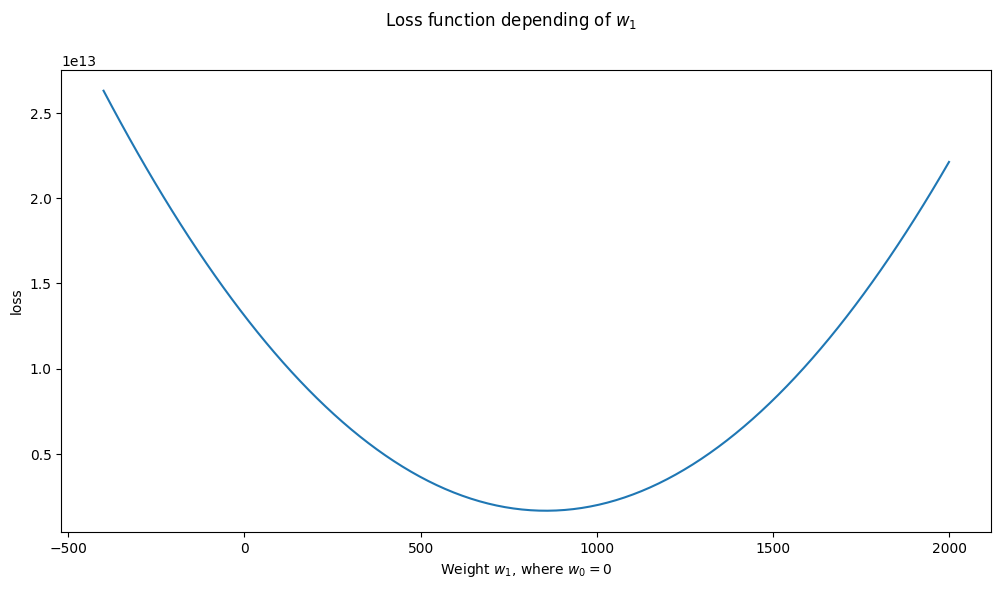

In [19]:
x = np.linspace(-400, 2000, 100)
y = [ loss_fuction( weight=(0, w), df=df_view, columns=[y_column,x_columns[0]] ) for w in x ]
#y = [ loss_fuction_mat(np.array([0, w]), df_view, x_columns[0:1], y_column ) for w in x ]
fig = plt.figure(figsize=(12,6))
plt.suptitle("Loss function depending of $w_1$")
# plt.grid()
plt.plot(x,y)
plt.xlabel("Weight $w_1$, where $w_0=0$")
plt.ylabel("loss")
plt.show()

# 3. Oдин крок градієнтного спуску

$$  
\nabla J(\vec{w}) =
\begin{pmatrix}
\frac{\partial J(\vec{w})}{\partial w_0} \\
\frac{\partial J(\vec{w})}{\partial w_1} \\
\frac{\partial J(\vec{w})}{\partial w_2} \\
.. \\
\frac{\partial J(\vec{w})}{\partial w_n} \\
\end{pmatrix}
=
\begin{pmatrix}
\frac{1}{m} \sum_{i=1}^{m} (h(x^{(i)}) - y^{(i)})\\
\frac{1}{m} \sum_{i=1}^{m} (h(x^{(i)}) - y^{(i)})x_1^{(i)} \\
\frac{1}{m} \sum_{i=1}^{m} (h(x^{(i)}) - y^{(i)})x_2^{(i)} \\
.. \\
\frac{1}{m} \sum_{i=1}^{m} (h(x^{(i)}) - y^{(i)})x_n^{(i)} \\
\end{pmatrix}
$$

$$
\vec{w}
=\vec{w}^{prev} − α \nabla J(\vec{w})
$$

$$
X_{m,n}=
\begin{bmatrix}
 1&  x^{(1)}_{1}&  x^{(1)}_{2}&  …&  x^{(1)}_{n}  \\
 1&  x^{(2)}_{1}&  x^{(2)}_{2}&  …&  x^{(2)}_{n}  \\
 1&  x^{(3)}_{1}&  x^{(3)}_{2}&  …&  x^{(3)}_{n}  \\
 \vdots&   \vdots&   \vdots&   \ddots&  \vdots&   \\
 1&  x^{(m)}_{1}&  x^{(m)}_{2}&  …&  x^{(m)}_{n}  \\
\end{bmatrix}​​
$$

$$
∇J(\vec{w})=\frac{1}{m}​  X^T(X \vec{w} - \vec{y}​)
$$

## Функції

In [20]:
def grad_step_mat(weight:np.array, x_matrix, y,
                  learning_rate:float = 0.01) -> np.array:
  m = x_matrix.shape[0]
  delta = x_matrix.dot(weight) - y
  step =  np.dot(x_matrix.T, delta) / m
  return weight - step*learning_rate

def grad_descent_mat(weight:np.array, df:pd.DataFrame, num_iter:int,
                     x_columns:list, y_column:str,
                     learning_rate:float=0.01, epsilon:float=0.01) -> tuple[list, list]:
  features = df[x_columns].values
  y_data = df[y_column].values
  x_matrix = np.concatenate((np.ones((features.shape[0], 1)), features), axis=1).astype("int64")
  weight = grad_step_mat(weight, x_matrix, y_data,  learning_rate=learning_rate)
  loss = loss_fuction_mat(weight, x_matrix, y_data)
  history_loss = [loss]
  for i in range(1, num_iter):
    weight = grad_step_mat(weight, x_matrix, y_data,  learning_rate=learning_rate)
    loss = loss_fuction_mat(weight, x_matrix, y_data)
    delta = abs(loss-history_loss[-1])
    if  delta < epsilon:
      print(f"{delta=}, {epsilon=}")
      break
    history_loss.append(loss)
  return list(weight), history_loss

### LOOP

In [21]:
def grad_step(weight, grads, learning_rate=0.01):
  w = np.array(weight)
  g = np.array(grads)
  w = w - learning_rate * g
  return list(w)

In [22]:
def grads_w_n(weight, df, columns):
  grads = []
  n = df.shape[0]
  for i, _ in enumerate(weight):
    cost = 0
    for y, *params in zip(*[df[column] for column in columns]):
      x = 1 if i == 0 else params[i-1]
      cost += (h(weight,params) - y)*x
    grads.append(cost/n)
  return grads

In [23]:
def grad_descent(weight, df, num_iter, columns, learning_rate=0.01, epsilon=0.01):
  loss = loss_fuction(weight, df, columns)
  history_loss = [loss]
  for i in range(num_iter):
    grads = grads_w_n(weight, df, columns)
    weight = grad_step(weight, grads, learning_rate=learning_rate)
    loss = loss_fuction(weight, df, columns)
    delta = abs(loss-history_loss[-1])
    if  delta < epsilon:
      print(f"{delta=}, {epsilon=}")
      history_loss.append(loss)
      break
    history_loss.append(loss)
  return weight, history_loss

### TECT

In [24]:
weight_t = np.zeros(len(x_columns)+1)
try:
  weight_t, history_loss_t = grad_descent_mat(weight_t, df_view.head(),
                                              10, x_columns, y_column,
                                              learning_rate=0.00000001,  epsilon=0.01)
  print(f"{weight_t=}")
  print(f"{len(history_loss_t)=}")
  print(f"{(history_loss_t)=}")
except Exception as err:
  print("********* ERROR:" ,err)

assert weight_t == [0.1942221618344967, 1465.1798936918199, 0.7815591817859213, 0.38703739209468957], f"Wrong weight {weight_t}"
assert history_loss_t[:3] == [8452503019908.784, 2065994174010.724, 1458932862538.786], f"Wrong history weight"

weight_t=[0.1942221618344967, 1465.1798936918199, 0.7815591817859213, 0.38703739209468957]
len(history_loss_t)=10
(history_loss_t)=[8452503019908.784, 2065994174010.724, 1458932862538.786, 1401229424219.296, 1395744484466.823, 1395223106221.071, 1395173532862.6123, 1395168806304.455, 1395168342600.6062, 1395168284096.8345]


In [25]:
weight_t = [4, 5, 6]
grads_t = [1, 0, -1]
assert grad_step(weight_t, grads_t, learning_rate=1) == [3, 5, 7], "Wrong grad_step result"

In [26]:
weight_t = (0,) * (len(x_columns)+1)
try:
  weight_t, history_loss_t = grad_descent(weight_t, df_view.head(),
                                          num_iter=10, columns=data_columns,
                                          learning_rate=0.00000001,  epsilon=0.01)
  print(f"{weight_t=}")
  print(f"{len(history_loss_t)=}")
except Exception as err:
  print("********* ERROR:" ,err)

assert weight_t == [0.19422216183449667, 1465.1798936918196, 0.7815591817859213, 0.38703739209468957], "Wrong result grad_descent"

weight_t=[0.19422216183449667, 1465.1798936918196, 0.7815591817859213, 0.38703739209468957]
len(history_loss_t)=11


# 4. Найкращі параметри $\vec{w}$ для датасету - прогнозуючу ціну на будинок залежно від площі, кількості ванних кімнат та кількості спалень

## Розрахунок

In [27]:
max_ephoh = 200
learning_rate = 0.00000001
epsilon=1e5

weight = np.zeros(len(x_columns)+1)
try:
  weight, history_loss = grad_descent_mat(weight_t, df_view, max_ephoh, x_columns, y_column,
                                          learning_rate,  epsilon)
  print(f"{weight=}")
  print(f"{len(history_loss)=}")
except Exception as err:
  print("********* ERROR:" ,err)

delta=73696.81079101562, epsilon=100000.0
weight=[0.1835516774799398, 855.7619359008528, 0.8194977549081557, 0.4454451386516973]
len(history_loss)=24


## Навчання крива

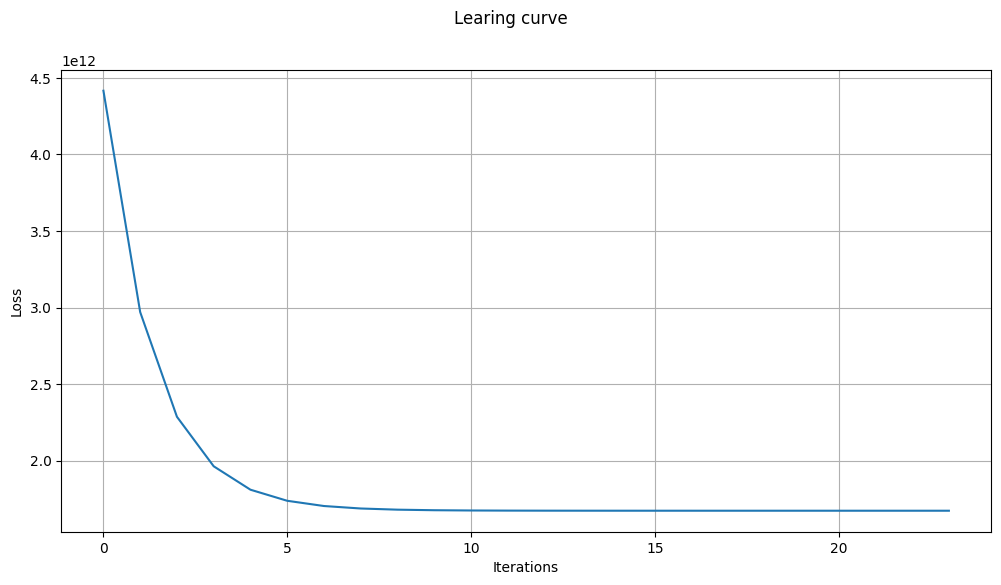

In [28]:
plt.figure(figsize=(12,6))
plt.suptitle("Learing curve")
plt.plot(history_loss)
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

## Виведення кінцевих значень параметрів

In [29]:
print("Градієнтний спуск coefficients:", weight[1:])
print("Градієнтний спуск intercept:", weight[0])

Градієнтний спуск coefficients: [855.7619359008528, 0.8194977549081557, 0.4454451386516973]
Градієнтний спуск intercept: 0.1835516774799398


# Результат

Найкращі параметри $\vec{w}$ : для h("price")
<!--

$ \vec{x} = \begin{pmatrix} 1 \\ 'area' \\ 'bedrooms'  \\ 'bathrooms'   \end{pmatrix},$
$ \vec{w} = \begin{pmatrix} {{weight}} \\ 852.5944583276267 \\ 0.6647954785106015\\ 0.3224243948019779 \end{pmatrix}$

weight=[0.20422371595564612, 852.5944583276267, 0.6647954785106015, 0.3224243948019779] -->

In [30]:
from IPython.display import display, Markdown

rows_x = " \\\\ ".join([ str(p) for p in x_columns ])
rows_w = " \\\\ ".join([ f"{p:.6f}" for p in weight ])
table_content = f"""
$ \\vec{{x}} = \\begin{{pmatrix}} 1 \\\\ {rows_x} \\end{{pmatrix}}$,
$ \\vec{{w}} = \\begin{{pmatrix}} {rows_w}  \\end{{pmatrix}}$
"""

display(Markdown(table_content))


$ \vec{x} = \begin{pmatrix} 1 \\ area \\ bedrooms \\ bathrooms \end{pmatrix}$,
$ \vec{w} = \begin{pmatrix} 0.183552 \\ 855.761936 \\ 0.819498 \\ 0.445445  \end{pmatrix}$


# Аналітичне рішення

## np.linalg

In [31]:
features = df[x_columns].values
y_data = df[y_column].values
x_matrix = np.concatenate((np.ones((features.shape[0], 1)), features), axis=1).astype("int64")

weigth_analytic = np.linalg.inv(x_matrix.T @ x_matrix) @ x_matrix.T @ y_data

print("Аналітичне рішення coefficients:", weigth_analytic[1:])
print("Аналітичне рішення intercept:", weigth_analytic[0])

Аналітичне рішення coefficients: [3.78762754e+02 4.06820034e+05 1.38604950e+06]
Аналітичне рішення intercept: -173171.6076326356


In [32]:
from IPython.display import display, Markdown

rows_x = " \\\\ ".join([ str(p) for p in x_columns ])
rows_w = " \\\\ ".join([ f"{p:.6f}" for p in weigth_analytic ])
table_content = f"""
$ \\vec{{x}} = \\begin{{pmatrix}} 1 \\\\ {rows_x} \\end{{pmatrix}}$,
$ \\vec{{w}} = \\begin{{pmatrix}} {rows_w}  \\end{{pmatrix}}$
"""

display(Markdown(table_content))


$ \vec{x} = \begin{pmatrix} 1 \\ area \\ bedrooms \\ bathrooms \end{pmatrix}$,
$ \vec{w} = \begin{pmatrix} -173171.607633 \\ 378.762754 \\ 406820.033769 \\ 1386049.497791  \end{pmatrix}$


## SciKit LinearRegression

In [33]:
regressor = LinearRegression()

In [34]:
X = df[x_columns]
X.shape

(545, 3)

In [35]:
regressor.fit(X, df[y_column])

LinearRegression()

In [36]:
regressor.coef_

array([3.78762754e+02, 4.06820034e+05, 1.38604950e+06])

In [37]:
regressor.intercept_

-173171.6076326361

In [38]:
weigth_scikit = np.concatenate((np.array([regressor.intercept_]), regressor.coef_), axis=0)
weigth_scikit

array([-1.73171608e+05,  3.78762754e+02,  4.06820034e+05,  1.38604950e+06])

In [39]:
from IPython.display import display, Markdown

rows_x = " \\\\ ".join([ str(p) for p in x_columns ])
rows_w = " \\\\ ".join([ f"{p:.6f}" for p in weigth_scikit ])
table_content = f"""
$ \\vec{{x}} = \\begin{{pmatrix}} 1 \\\\ {rows_x} \\end{{pmatrix}}$,
$ \\vec{{w}} = \\begin{{pmatrix}} {rows_w}  \\end{{pmatrix}}$
"""

display(Markdown(table_content))


$ \vec{x} = \begin{pmatrix} 1 \\ area \\ bedrooms \\ bathrooms \end{pmatrix}$,
$ \vec{w} = \begin{pmatrix} -173171.607633 \\ 378.762754 \\ 406820.033769 \\ 1386049.497791  \end{pmatrix}$


## Аналітичний аналіз

In [40]:
df_view[x_columns].median()

area         4600.0
bedrooms        3.0
bathrooms       1.0
dtype: float64

In [41]:
print(df_view.head(1))
p = {"area": 7420, "bedrooms": 4, "bathrooms": 2 }
price = int(h(weight,(p.get("area"), p.get("bedrooms"), p.get("bathrooms"))))
print(f"source: {p=}, predict: {price=}")

      price  area  bedrooms  bathrooms
0  13300000  7420         4          2
source: p={'area': 7420, 'bedrooms': 4, 'bathrooms': 2}, predict: price=6349757


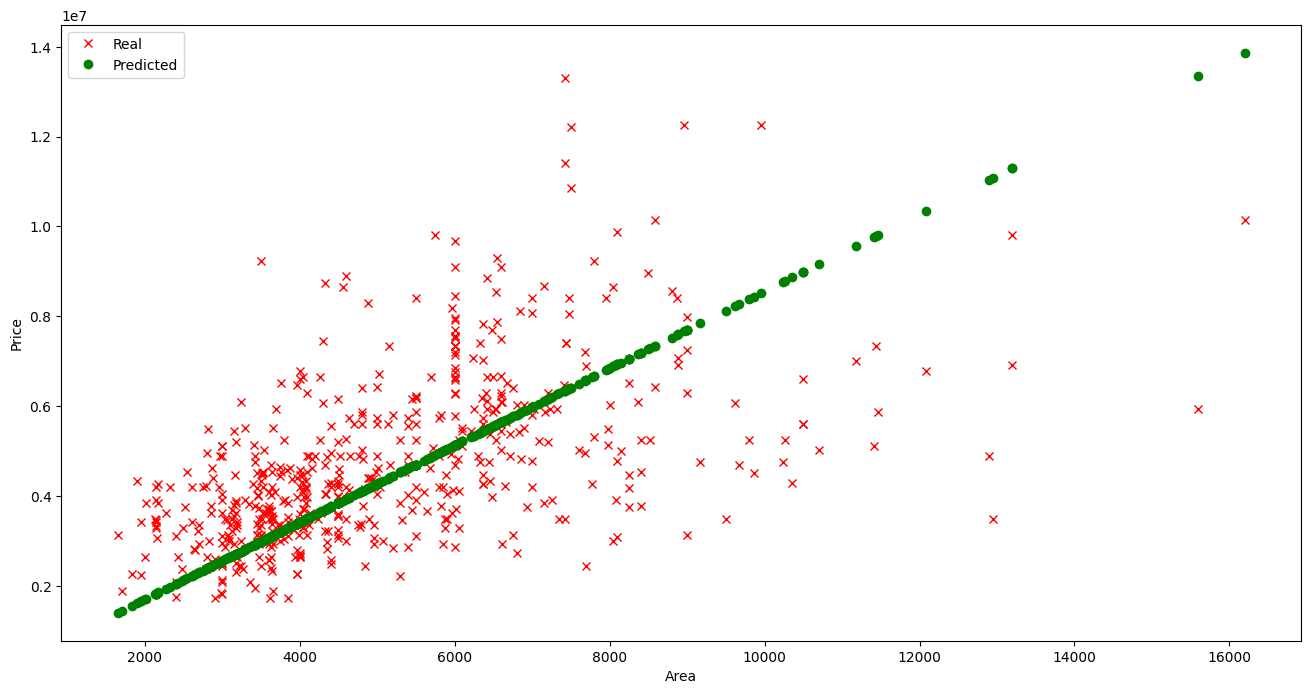

In [42]:
prediced_price = df_view[x_columns].apply(lambda x: h(weight, x) , axis=1)
plt.figure(figsize=(16,8))
data_x = df_view[data_columns[1]]
data_y = df_view[data_columns[0]]
data_p = prediced_price
plt.plot(data_x, data_y, 'rx', label = "Real")
plt.plot(data_x, data_p, 'go', label = "Predicted")
plt.legend()
plt.ylabel("Price")
plt.xlabel("Area")
plt.show()

[0.1835516774799398, 855.7619359008528, 0.8194977549081557, 0.4454451386516973]


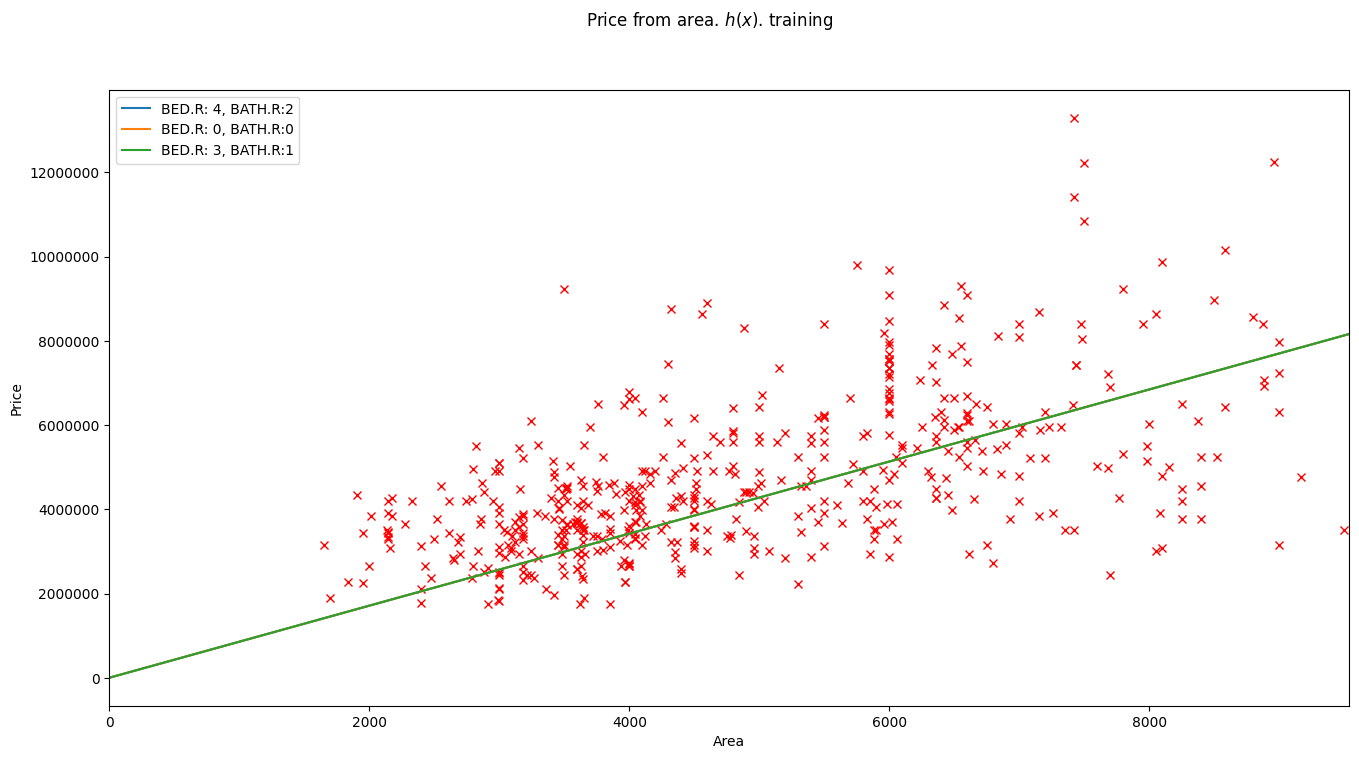

In [43]:
print(weight)
predit_set = [
{"bedrooms": 4, "bathrooms": 2 },
{"bedrooms": 0, "bathrooms": 0 },
{"bedrooms": 3, "bathrooms": 1 },
]
plt.figure(figsize=(16,8))
plt.suptitle("Price from area. $h(x)$. training")
plt.ticklabel_format(scilimits=(-5, 18))
data_x = df_view[data_columns[1]]
data_y = df_view[data_columns[0]]
data_x_up =  int(data_x.describe()['75%']*1.5)
#print(f"{data_x_up=}")
x_limit = (0, data_x_up)
plt.plot(data_x, data_y, 'rx')
x = np.linspace(x_limit[0],x_limit[1],500)
for p in predit_set:
  plt.plot(x, h_loop(weight,(x, p.get("bedrooms"), p.get("bathrooms"))), label=f'BED.R: { p.get("bedrooms")}, BATH.R:{p.get("bathrooms")}')
plt.xlim(x_limit)
#plt.grid()
plt.legend()
plt.ylabel("Price")
plt.xlabel("Area")
plt.show()

# Diagram

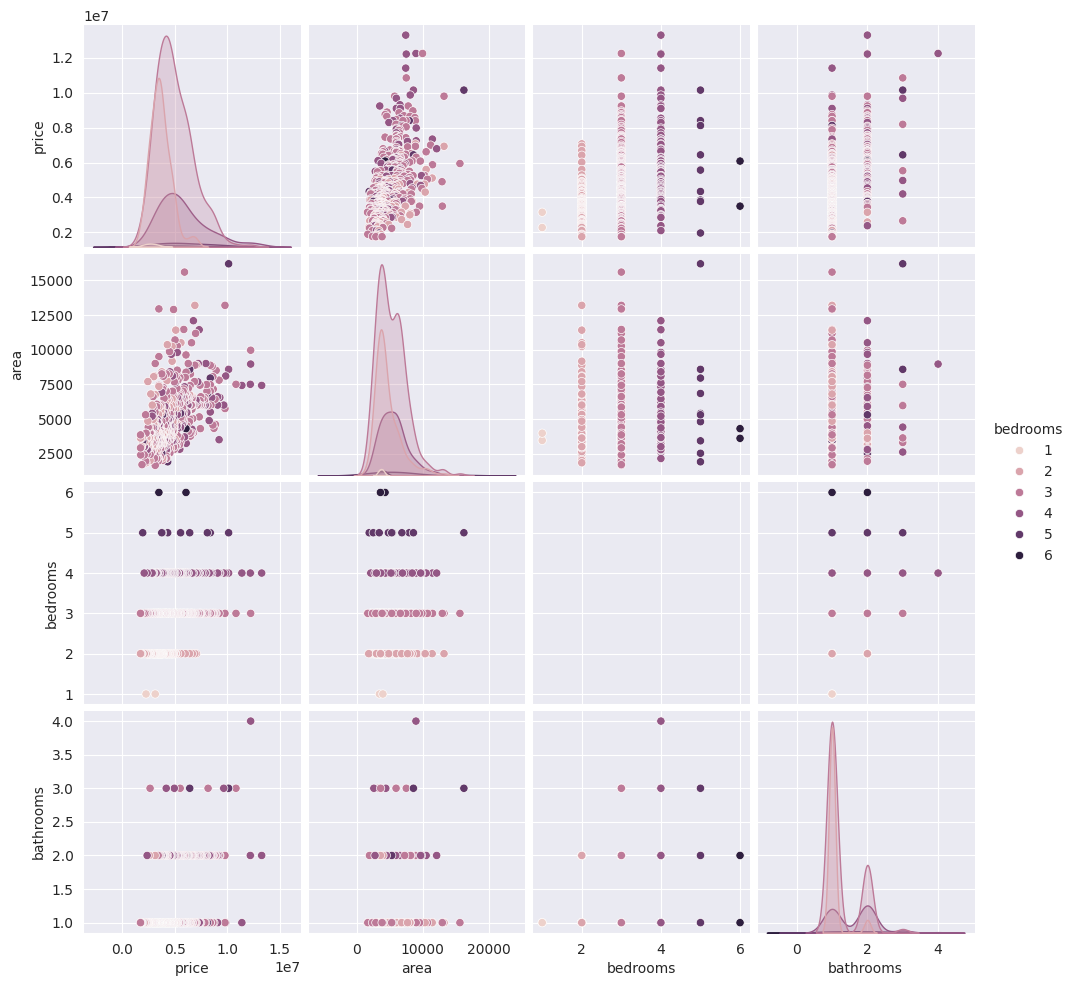

In [44]:
sns.set_style('darkgrid')
sns.pairplot(df_view, vars = data_columns, hue ='bedrooms')
plt.show()

In [45]:
x = np.linspace(0,10,5)
a = np.array(x)
print(a)

[ 0.   2.5  5.   7.5 10. ]


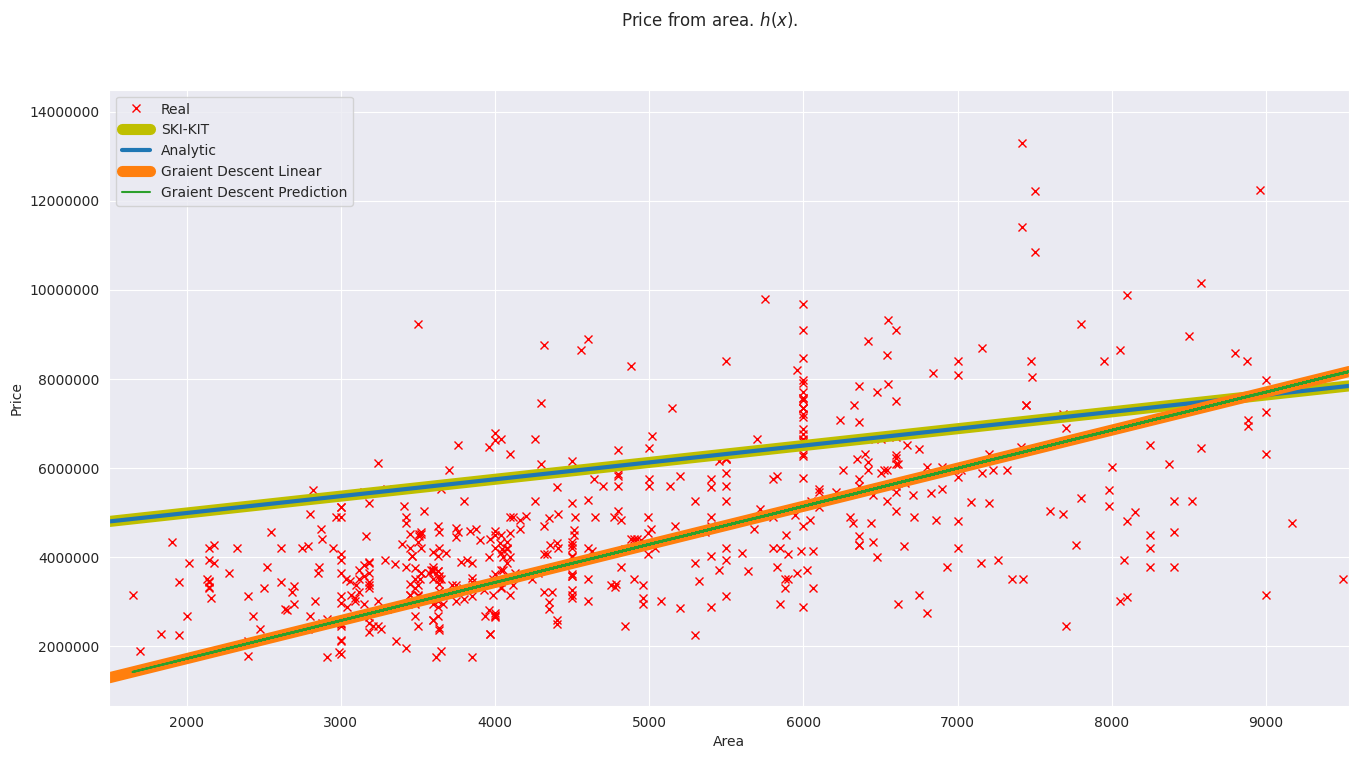

In [46]:
weight_skit_1 = [regressor.intercept_] + list(regressor.coef_)


plt.figure(figsize=(16,8))
plt.suptitle("Price from area. $h(x)$.")
plt.ticklabel_format(scilimits=(-5, 18))
data_x = df_view[data_columns[1]]
data_y = df_view[data_columns[0]]
data_x_up =  int(data_x.describe()['75%']*1.5)
#print(f"{data_x_up=}")
x_limit = (1500, data_x_up)
plt.plot(data_x, data_y, 'rx', label = "Real")
x = np.linspace(x_limit[0],x_limit[1],5)
plt.plot(x, h_loop( weight_skit_1 , (x , 4, 2) ), "y-", linewidth=8, label="SKI-KIT")
plt.plot(x, h_loop( weigth_analytic , (x , 4, 2) ),  linewidth=3, label="Analytic")

plt.plot(x, h_loop( weight, (x , 4, 2) ),  linewidth=8, label="Graient Descent Linear")
plt.plot(data_x, prediced_price, label="Graient Descent Prediction")
plt.xlim(x_limit)
#plt.grid()
plt.legend()
plt.ylabel("Price")
plt.xlabel("Area")
plt.show()